<a href="https://colab.research.google.com/github/veronica1013/Moringa_Week3_IP/blob/main/Updated_Starter_notebook_blood_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Load the files
train = pd.read_csv("Train_trimmed.csv")
test = pd.read_csv("Test_trimmed.csv")

## Quick look at the DATA

In [ ]:
test.head(3)

,Reading_ID,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance110,absorbance111,absorbance112,absorbance113,absorbance114,absorbance115,absorbance116,absorbance117,absorbance118,absorbance119,absorbance120,absorbance121,absorbance122,absorbance123,absorbance124,absorbance125,absorbance126,absorbance127,absorbance128,absorbance129,absorbance130,absorbance131,absorbance132,absorbance133,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,temperature,humidity
0,ID_37BEI22R,0.540020,0.550252,0.555062,0.555983,0.562491,0.559443,0.562695,0.558805,0.559067,0.557602,0.554924,0.553300,0.549671,0.548033,0.544539,0.542640,0.541228,0.540335,0.539378,0.539134,0.538375,0.538068,0.540340,0.541754,0.543920,0.547749,0.550490,0.553550,0.559024,0.562538,0.568940,0.574474,0.588116,0.604365,0.634176,0.663675,0.691110,0.709235,0.724206,...,1.446511,1.445413,1.437354,1.431712,1.431223,1.429847,1.423059,1.417072,1.407601,1.401527,1.407248,1.393886,1.389147,1.385912,1.377751,1.372950,1.366470,1.360301,1.351162,1.346405,1.350380,1.340395,1.326046,1.324390,1.322257,1.314661,1.308962,1.308751,1.298821,1.285794,1.294162,1.286025,1.288414,1.287432,1.266873,1.272191,1.270802,1.263687,40.88,25.70
1,ID_4W85V5DV,0.603260,0.609797,0.613326,0.616530,0.617400,0.617284,0.615343,0.611668,0.608864,0.606411,0.602919,0.599854,0.597024,0.592800,0.590059,0.586417,0.585922,0.583848,0.583204,0.582259,0.581994,0.582528,0.584993,0.587332,0.590686,0.591674,0.595796,0.599694,0.605431,0.608592,0.613355,0.621625,0.633154,0.655163,0.682106,0.711647,0.739428,0.763052,0.776542,...,1.713526,1.707476,1.690848,1.681204,1.662508,1.653222,1.637013,1.619334,1.613559,1.585294,1.574029,1.563284,1.553378,1.538660,1.524748,1.508455,1.495151,1.494071,1.476984,1.459555,1.449668,1.444659,1.432336,1.425302,1.407856,1.404927,1.400641,1.385942,1.380131,1.367970,1.367653,1.364312,1.357998,1.348350,1.346009,1.330666,1.334532,1.335588,42.35,30.16
2,ID_L4YR3NDY,0.520005,0.526073,0.529009,0.530775,0.530869,0.529993,0.529816,0.525386,0.522270,0.518925,0.516824,0.514363,0.510227,0.506540,0.503605,0.501884,0.499315,0.498547,0.497386,0.496028,0.495754,0.495847,0.495887,0.497499,0.499683,0.501803,0.504862,0.508623,0.511230,0.516046,0.520374,0.526093,0.536272,0.557057,0.579567,0.604739,0.630935,0.650413,0.664835,...,1.598508,1.578582,1.565059,1.547104,1.530812,1.516311,1.494052,1.481146,1.469487,1.443511,1.430992,1.411109,1.392950,1.382620,1.359417,1.348743,1.334049,1.325644,1.307332,1.295699,1.284021,1.276139,1.262930,1.252719,1.237859,1.231942,1.223501,1.213700,1.206026,1.197681,1.197900,1.196079,1.185196,1.175500,1.169110,1.165897,1.165072,1.167966,42.83,25.51


In [ ]:
# Read first 3 rows
train.head(3)

,Reading_ID,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance113,absorbance114,absorbance115,absorbance116,absorbance117,absorbance118,absorbance119,absorbance120,absorbance121,absorbance122,absorbance123,absorbance124,absorbance125,absorbance126,absorbance127,absorbance128,absorbance129,absorbance130,absorbance131,absorbance132,absorbance133,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human
0,ID_3SSHI56C,0.561557,0.568417,0.571877,0.570884,0.569032,0.567476,0.565662,0.561901,0.559722,0.557474,0.554371,0.552386,0.548702,0.544238,0.542579,0.540514,0.538980,0.536650,0.536483,0.535447,0.537577,0.535715,0.536895,0.539589,0.541081,0.544893,0.547765,0.551773,0.554599,0.561290,0.566327,0.572561,0.584058,0.600599,0.623070,0.658285,0.686114,0.709545,0.724821,...,1.654336,1.638999,1.625188,1.606235,1.589153,1.572245,1.562602,1.532526,1.521140,1.506031,1.489166,1.469838,1.462617,1.445696,1.435586,1.417847,1.404205,1.388861,1.377436,1.364444,1.360373,1.341243,1.339632,1.321471,1.317444,1.311209,1.291677,1.285579,1.285488,1.275784,1.271104,1.264029,1.250779,1.254856,1.255224,42.51,34.01,ok,ok,ok
1,ID_599OOLZA,0.558420,0.565449,0.569717,0.570999,0.569969,0.568405,0.566628,0.564101,0.559951,0.556193,0.552271,0.550086,0.546207,0.542366,0.539789,0.537221,0.534336,0.533868,0.533018,0.532227,0.530818,0.532171,0.533658,0.535266,0.538939,0.542399,0.546479,0.550606,0.554408,0.561437,0.567867,0.576763,0.589781,0.610399,0.643898,0.674421,0.701734,0.722878,0.737284,...,1.744440,1.732909,1.713039,1.700202,1.671141,1.659254,1.646976,1.612735,1.615917,1.594293,1.582486,1.552979,1.541997,1.533186,1.518359,1.498964,1.488043,1.472946,1.465925,1.452647,1.437819,1.423670,1.415103,1.401141,1.403560,1.384169,1.379410,1.374128,1.356969,1.352693,1.342430,1.339714,1.332805,1.336324,1.342537,44.52,32.09,ok,high,high
2,ID_MVJGPQ75,0.530362,0.538530,0.543128,0.546287,0.547001,0.547120,0.546351,0.544254,0.542802,0.542207,0.539779,0.536417,0.533380,0.531117,0.529093,0.526101,0.524599,0.522952,0.521551,0.521149,0.520478,0.521432,0.521473,0.523567,0.525816,0.527889,0.530697,0.533416,0.540124,0.542980,0.549363,0.557174,0.566935,0.587410,0.619436,0.649492,0.680652,0.702569,0.719124,...,1.646114,1.638657,1.626555,1.610017,1.596801,1.585333,1.579274,1.561209,1.539060,1.544212,1.525989,1.516723,1.502255,1.489132,1.483308,1.461028,1.453174,1.450412,1.437784,1.422148,1.415880,1.404698,1.388143,1.397241,1.385680,1.376355,1.357758,1.354854,1.345476,1.333810,1.332739,1.335550,1.326775,1.336862,1.316860,45.77,24.80,ok,ok,high


The goal of the competition is use the abosrbance which is spectrum to predict the hdl_cholesterol, hemoglobin and ldl_cholestorl level. These can either be low, ok or high. The absobance spectrum has 170 values over the entier frequency range. In the dataset with labels trim, the edges of the absorbance spectrum have been trimmed by Bloods-ai because they believed the edges are noisy. 

It is up to you to experiment and decide if woriking with the full range or trim range prvents the best results.

Note that the each measurement actually contains, 60 scans so a lot of the data will actually just be scans of the same measurement. So it is up to you to make sure your model doesn't overfit and is reliable to the limited variation of the data. The plan is to collect and add more data while the competion is running.

### Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


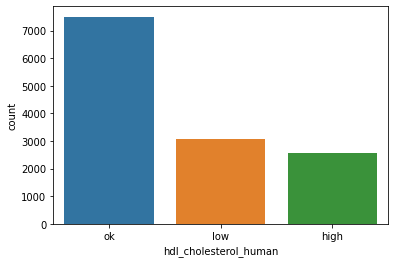

In [ ]:
sns.countplot(train["hdl_cholesterol_human"]);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


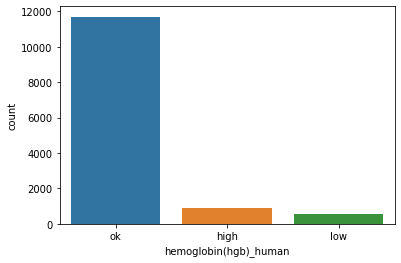

In [ ]:
sns.countplot(train["hemoglobin(hgb)_human"]);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


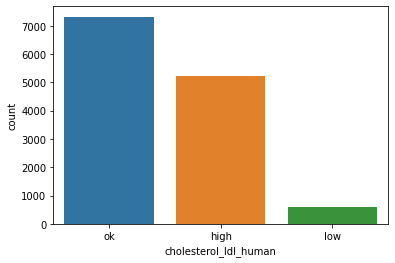

In [ ]:
sns.countplot(train["cholesterol_ldl_human"]);

In [ ]:
train.iloc[0, 1:173]

absorbance0              0.561557
absorbance1              0.568417
absorbance2              0.571877
absorbance3              0.570884
absorbance4              0.569032
                           ...   
temperature                 42.51
humidity                    34.01
hdl_cholesterol_human          ok
hemoglobin(hgb)_human          ok
cholesterol_ldl_human          ok
Name: 0, Length: 153, dtype: object

In [ ]:
train.head(3)

,Reading_ID,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance113,absorbance114,absorbance115,absorbance116,absorbance117,absorbance118,absorbance119,absorbance120,absorbance121,absorbance122,absorbance123,absorbance124,absorbance125,absorbance126,absorbance127,absorbance128,absorbance129,absorbance130,absorbance131,absorbance132,absorbance133,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human
0,ID_3SSHI56C,0.561557,0.568417,0.571877,0.570884,0.569032,0.567476,0.565662,0.561901,0.559722,0.557474,0.554371,0.552386,0.548702,0.544238,0.542579,0.540514,0.538980,0.536650,0.536483,0.535447,0.537577,0.535715,0.536895,0.539589,0.541081,0.544893,0.547765,0.551773,0.554599,0.561290,0.566327,0.572561,0.584058,0.600599,0.623070,0.658285,0.686114,0.709545,0.724821,...,1.654336,1.638999,1.625188,1.606235,1.589153,1.572245,1.562602,1.532526,1.521140,1.506031,1.489166,1.469838,1.462617,1.445696,1.435586,1.417847,1.404205,1.388861,1.377436,1.364444,1.360373,1.341243,1.339632,1.321471,1.317444,1.311209,1.291677,1.285579,1.285488,1.275784,1.271104,1.264029,1.250779,1.254856,1.255224,42.51,34.01,ok,ok,ok
1,ID_599OOLZA,0.558420,0.565449,0.569717,0.570999,0.569969,0.568405,0.566628,0.564101,0.559951,0.556193,0.552271,0.550086,0.546207,0.542366,0.539789,0.537221,0.534336,0.533868,0.533018,0.532227,0.530818,0.532171,0.533658,0.535266,0.538939,0.542399,0.546479,0.550606,0.554408,0.561437,0.567867,0.576763,0.589781,0.610399,0.643898,0.674421,0.701734,0.722878,0.737284,...,1.744440,1.732909,1.713039,1.700202,1.671141,1.659254,1.646976,1.612735,1.615917,1.594293,1.582486,1.552979,1.541997,1.533186,1.518359,1.498964,1.488043,1.472946,1.465925,1.452647,1.437819,1.423670,1.415103,1.401141,1.403560,1.384169,1.379410,1.374128,1.356969,1.352693,1.342430,1.339714,1.332805,1.336324,1.342537,44.52,32.09,ok,high,high
2,ID_MVJGPQ75,0.530362,0.538530,0.543128,0.546287,0.547001,0.547120,0.546351,0.544254,0.542802,0.542207,0.539779,0.536417,0.533380,0.531117,0.529093,0.526101,0.524599,0.522952,0.521551,0.521149,0.520478,0.521432,0.521473,0.523567,0.525816,0.527889,0.530697,0.533416,0.540124,0.542980,0.549363,0.557174,0.566935,0.587410,0.619436,0.649492,0.680652,0.702569,0.719124,...,1.646114,1.638657,1.626555,1.610017,1.596801,1.585333,1.579274,1.561209,1.539060,1.544212,1.525989,1.516723,1.502255,1.489132,1.483308,1.461028,1.453174,1.450412,1.437784,1.422148,1.415880,1.404698,1.388143,1.397241,1.385680,1.376355,1.357758,1.354854,1.345476,1.333810,1.332739,1.335550,1.326775,1.336862,1.316860,45.77,24.80,ok,ok,high


You can drop the id column and then convert the data to numpy array

In [ ]:
train.columns

Index(['Reading_ID', 'absorbance0', 'absorbance1', 'absorbance2',
       'absorbance3', 'absorbance4', 'absorbance5', 'absorbance6',
       'absorbance7', 'absorbance8',
       ...
       'absorbance143', 'absorbance144', 'absorbance145', 'absorbance146',
       'absorbance147', 'temperature', 'humidity', 'hdl_cholesterol_human',
       'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
      dtype='object', length=154)

In [ ]:
# Drop the Reading ID column
train.drop(["Reading_ID"], axis=1, inplace=True)

In [ ]:
# Find the interquartile range
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

absorbance0       0.049295
absorbance1       0.049156
absorbance2       0.049158
absorbance3       0.049390
absorbance4       0.049318
                   ...    
absorbance145     0.075436
absorbance146     0.075514
absorbance147     0.075675
temperature       3.840000
humidity         11.642500
Length: 150, dtype: float64


In [ ]:
# Check for outliers using Inter Quartile Range
print((train < (Q1 - 1.5 * IQR)) |(train > (Q3 + 1.5 * IQR)))

       absorbance0  absorbance1  ...  humidity  temperature
0            False        False  ...     False        False
1            False        False  ...     False        False
2            False        False  ...     False        False
3            False        False  ...     False        False
4            False        False  ...     False        False
...            ...          ...  ...       ...          ...
13135        False        False  ...     False        False
13136        False        False  ...     False        False
13137        False        False  ...     False        False
13138        False        False  ...     False        False
13139        False        False  ...     False        False

[13140 rows x 153 columns]


In [ ]:
# Remove outliers using IQR
train_df = train.copy(deep=True)
clean_df = train_df[~((train_df < (Q1 - 1.5 * IQR)) |(train_df > (Q3 + 1.5 * IQR))).any(axis=1)]
clean_df.shape

(12255, 153)

In [ ]:
train_df.shape

(13140, 153)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13140 entries, 0 to 13139
Columns: 153 entries, absorbance0 to cholesterol_ldl_human
dtypes: float64(150), object(3)
memory usage: 15.3+ MB


In [ ]:
train_df.dtypes

absorbance0              float64
absorbance1              float64
absorbance2              float64
absorbance3              float64
absorbance4              float64
                          ...   
temperature              float64
humidity                 float64
hdl_cholesterol_human     object
hemoglobin(hgb)_human     object
cholesterol_ldl_human     object
Length: 153, dtype: object

In [ ]:
# Select columns with object data type
train_df.select_dtypes(np.object).head(3)

,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human
0,ok,ok,ok
1,ok,high,high
2,ok,ok,high


In [ ]:
# Select columns with object data type
clean_df.select_dtypes(np.object).head(3)

,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human
0,ok,ok,ok
1,ok,high,high
2,ok,ok,high


In [ ]:
# # Apply normalization techniques on temperature and humidity columns
# column = ['temperature', 'humidity']
# clean_df[column] = clean_df[column] /clean_df[column].abs().max()
# clean_df.head(2)

In [ ]:
clean_df[['absorbance101',	'absorbance102',	'absorbance103']].dtypes

absorbance101    float64
absorbance102    float64
absorbance103    float64
dtype: object

In [ ]:
# Change absorbance101, absorbance102,	absorbance103 columns to float data type
clean_df[['absorbance101',	'absorbance102',	'absorbance103']] = clean_df[['absorbance101',	'absorbance102','absorbance103']].astype(float)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# Change the dataframe to numpy array
data = clean_df.to_numpy()
print(data.shape) # 219 IDs

(12255, 153)


In [ ]:
clean_df.shape

(12255, 153)

The first 170 columns are the abosrbance values, 170 to 172 are the temperature and humidity of the scanner, and the last 3 columns are the values you want to your model to predict 

In [ ]:
clean_df.columns

Index(['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3',
       'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7',
       'absorbance8', 'absorbance9',
       ...
       'absorbance143', 'absorbance144', 'absorbance145', 'absorbance146',
       'absorbance147', 'temperature', 'humidity', 'hdl_cholesterol_human',
       'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
      dtype='object', length=153)

## Feature selection using univariate feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
#features = np.array(data[:,:150], dtype=float) # to add dtype=float
labels = data[:, 150:]

In [ ]:
y= data[:, 151] # hemoglobin(hgb)_human (The second one)
y

array(['ok', 'high', 'ok', ..., 'ok', 'ok', 'ok'], dtype=object)

In [ ]:
y1 = data[:, 150] # hdl_cholesterol_human (The first one)
y1

array(['ok', 'ok', 'ok', ..., 'ok', 'ok', 'high'], dtype=object)

In [ ]:
y2 = data[:, 152] # cholesterol_ldl_human (The third one)
y2

array(['ok', 'high', 'high', ..., 'ok', 'ok', 'high'], dtype=object)

In [ ]:
# Drop the three target variables to choose the X or independentvariables/features
X= clean_df.drop(columns=['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],axis=1)
y= data[:, 151] # set hemoglobin(hgb)_human to y for feature selection
y1 = data[:, 150] # hdl_cholesterol_human (The first one)
#X = features
#y = labels
#y1= clean_df['hemoglobin(hgb)_human'].astype(int)
#y2= clean_df['cholesterol_ldl_human'].astype(int)

## Feature Selection for hemoglobin(hgb)_human 

In [ ]:
uni = SelectKBest(score_func = f_classif, k = 10)
fit = uni.fit(X, y)

In [ ]:
X.columns[fit.get_support(indices=True)].tolist()

['absorbance82',
 'absorbance83',
 'absorbance84',
 'absorbance85',
 'absorbance86',
 'absorbance87',
 'absorbance131',
 'absorbance134',
 'absorbance135',
 'absorbance137']

In [ ]:
features = clean_df[['absorbance82',
 'absorbance83',
 'absorbance84',
 'absorbance85',
 'absorbance86',
 'absorbance87',
 'absorbance131',
 'absorbance134',
 'absorbance135',
 'absorbance137']]

In [ ]:
#features = np.array(data[:,:150]) # to add dtype=float
labels = data[:, 150:]

So using these features and labels, you can go ahead to train you machine learning

## Feature selection for hdl_cholesterol_human

In [ ]:
uni = SelectKBest(score_func = f_classif, k = 10)
fit = uni.fit(X, y1)

In [ ]:
X.columns[fit.get_support(indices=True)].tolist()

['absorbance0',
 'absorbance1',
 'absorbance2',
 'absorbance34',
 'absorbance35',
 'absorbance36',
 'absorbance37',
 'absorbance38',
 'absorbance71',
 'humidity']

In [ ]:
features_1 = clean_df[[
  'absorbance0',
 'absorbance1',
 'absorbance2',
 'absorbance34',
 'absorbance35',
 'absorbance36',
 'absorbance37',
 'absorbance38',
 'absorbance71',
 'humidity']]

## Feature Selection for cholesterol_ldl_human (The third one)

In [ ]:
uni = SelectKBest(score_func = f_classif, k = 10)
fit = uni.fit(X, y2)

In [ ]:
X.columns[fit.get_support(indices=True)].tolist()

['absorbance87',
 'absorbance88',
 'absorbance89',
 'absorbance90',
 'absorbance91',
 'absorbance92',
 'absorbance109',
 'absorbance112',
 'absorbance113',
 'absorbance115']

### Create one feature selection list

In [ ]:
features_final= clean_df[['absorbance87',
 'absorbance88',
 'absorbance89',
 'absorbance90',
 'absorbance91',
 'absorbance92',
 'absorbance109',
 'absorbance112',
 'absorbance113',
 'absorbance115',
 'absorbance0',
 'absorbance1',
 'absorbance2',
 'absorbance34',
 'absorbance35',
 'absorbance36',
 'absorbance37',
 'absorbance38',
 'absorbance71',
 'humidity',
 'absorbance82',
 'absorbance83',
 'absorbance84',
 'absorbance85',
 'absorbance86',
 'absorbance87',
 'absorbance131',
 'absorbance134',
 'absorbance135',
 'absorbance137']]


## Saving the predictions

In [ ]:
# Preview first 3 rows of the test dataset
test.head(3)

,Reading_ID,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance110,absorbance111,absorbance112,absorbance113,absorbance114,absorbance115,absorbance116,absorbance117,absorbance118,absorbance119,absorbance120,absorbance121,absorbance122,absorbance123,absorbance124,absorbance125,absorbance126,absorbance127,absorbance128,absorbance129,absorbance130,absorbance131,absorbance132,absorbance133,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,temperature,humidity
0,ID_37BEI22R,0.540020,0.550252,0.555062,0.555983,0.562491,0.559443,0.562695,0.558805,0.559067,0.557602,0.554924,0.553300,0.549671,0.548033,0.544539,0.542640,0.541228,0.540335,0.539378,0.539134,0.538375,0.538068,0.540340,0.541754,0.543920,0.547749,0.550490,0.553550,0.559024,0.562538,0.568940,0.574474,0.588116,0.604365,0.634176,0.663675,0.691110,0.709235,0.724206,...,1.446511,1.445413,1.437354,1.431712,1.431223,1.429847,1.423059,1.417072,1.407601,1.401527,1.407248,1.393886,1.389147,1.385912,1.377751,1.372950,1.366470,1.360301,1.351162,1.346405,1.350380,1.340395,1.326046,1.324390,1.322257,1.314661,1.308962,1.308751,1.298821,1.285794,1.294162,1.286025,1.288414,1.287432,1.266873,1.272191,1.270802,1.263687,40.88,25.70
1,ID_4W85V5DV,0.603260,0.609797,0.613326,0.616530,0.617400,0.617284,0.615343,0.611668,0.608864,0.606411,0.602919,0.599854,0.597024,0.592800,0.590059,0.586417,0.585922,0.583848,0.583204,0.582259,0.581994,0.582528,0.584993,0.587332,0.590686,0.591674,0.595796,0.599694,0.605431,0.608592,0.613355,0.621625,0.633154,0.655163,0.682106,0.711647,0.739428,0.763052,0.776542,...,1.713526,1.707476,1.690848,1.681204,1.662508,1.653222,1.637013,1.619334,1.613559,1.585294,1.574029,1.563284,1.553378,1.538660,1.524748,1.508455,1.495151,1.494071,1.476984,1.459555,1.449668,1.444659,1.432336,1.425302,1.407856,1.404927,1.400641,1.385942,1.380131,1.367970,1.367653,1.364312,1.357998,1.348350,1.346009,1.330666,1.334532,1.335588,42.35,30.16
2,ID_L4YR3NDY,0.520005,0.526073,0.529009,0.530775,0.530869,0.529993,0.529816,0.525386,0.522270,0.518925,0.516824,0.514363,0.510227,0.506540,0.503605,0.501884,0.499315,0.498547,0.497386,0.496028,0.495754,0.495847,0.495887,0.497499,0.499683,0.501803,0.504862,0.508623,0.511230,0.516046,0.520374,0.526093,0.536272,0.557057,0.579567,0.604739,0.630935,0.650413,0.664835,...,1.598508,1.578582,1.565059,1.547104,1.530812,1.516311,1.494052,1.481146,1.469487,1.443511,1.430992,1.411109,1.392950,1.382620,1.359417,1.348743,1.334049,1.325644,1.307332,1.295699,1.284021,1.276139,1.262930,1.252719,1.237859,1.231942,1.223501,1.213700,1.206026,1.197681,1.197900,1.196079,1.185196,1.175500,1.169110,1.165897,1.165072,1.167966,42.83,25.51


In [ ]:
test_data= test[[
                 'Reading_ID',
                 'absorbance82',
                 'absorbance83',
                 'absorbance84',
                 'absorbance85',
                 'absorbance86',
                 'absorbance87',
                 'absorbance131',
                 'absorbance134',
                 'absorbance135',
                 'absorbance137']]              

In [ ]:
# test_data = test[[
#                   'absorbance87',
#  'absorbance88',
#  'absorbance89',
#  'absorbance90',
#  'absorbance91',
#  'absorbance92',
#  'absorbance109',
#  'absorbance112',
#  'absorbance113',
#  'absorbance115',
#  'Reading_ID',
#  'absorbance0',
#  'absorbance1',
#  'absorbance2',
#  'absorbance34',
#  'absorbance35',
#  'absorbance36',
#  'absorbance37',
#  'absorbance38',
#  'absorbance71',
#  'humidity',
#  'absorbance82',
#  'absorbance83',
#  'absorbance84',
#  'absorbance85',
#  'absorbance86',
#  'absorbance87',
#  'absorbance131',
#  'absorbance134',
#  'absorbance135',
#  'absorbance137'
# ]]

In [ ]:
# test_data_1= test[['Reading_ID','absorbance0',
#  'absorbance1',
#  'absorbance2',
#  'absorbance34',
#  'absorbance35',
#  'absorbance36',
#  'absorbance37',
#  'absorbance38',
#  'absorbance71',
#  'humidity']]

In [ ]:
# save it ids before dropping them
idx = test_data.Reading_ID.values
test_data.drop(["Reading_ID"], axis=1, inplace=True)
testdata = test_data.to_numpy()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(test_data.shape) # 61 Individuals

(3660, 10)


In [ ]:
# # Import the libraries
# from sklearn.datasets import make_classification
# #from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
# from sklearn.metrics import roc_curve, auc, roc_auc_score

# from imblearn.over_sampling import SVMSMOTE
# class_bal = SVMSMOTE(random_state = 101)

# # Choosing a sample
# X_class_bal, y_class_bal = make_classification(n_samples=1000, n_features=2,
#                                                          n_redundant=0, n_clusters_per_class=1,
#                                                          weights=[0.99], flip_y=0, random_state=101)

# # Solving Class imbalance
# X_class_bal, y_class_bal = class_bal.fit_resample(features, y)

### Basic model example

The goal of the project is to classify the level of cholesterol low, cholesterol high and hemoglobin. Your prediction should be something of the form ok, low and high. So you will to build and train a multioutput classfier. Below is basic example using sklearn.

Key:
low  = 0,
ok   = 1,
high = 2

In [ ]:
labels_n = np.zeros(labels.shape)
labels_n[np.where(labels=='low')] = 0
labels_n[np.where(labels=='ok')] = 1
labels_n[np.where(labels=='high')] = 2

In [ ]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [ ]:
#features = features_final

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_multilabel_classification
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline


In [ ]:
n_samples, n_features = features.shape 
n_outputs = labels_n.shape[1]
n_classes = 3

In [ ]:
features, label_n = make_multilabel_classification(n_samples=n_samples, n_features=n_features, n_classes=3, random_state=88)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(features, label_n, train_size=0.8, random_state=88)

In [ ]:
# from imblearn.over_sampling import SVMSMOTE
# class_bal = SVMSMOTE(random_state = 88)

# # # Choosing a sample
# X_class_bal, y_class_bal = make_classification(n_samples=n_samples, n_features=3,
#                                                           n_redundant=0, n_clusters_per_class=1,
#                                                           weights=[0.99], flip_y=0, random_state=88)

# # Solve class imbalance
# X_class_bal, y_class_bal = class_bal.fit_resample(xtrain, ytrain)

In [ ]:
# n_samples, n_features = features.shape # use xtrain instead of features
# n_outputs = labels_n.shape[1]
# n_classes = 3
forest = RandomForestClassifier(random_state=1, n_estimators=1000, class_weight='balanced')
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
model = multi_target_forest.fit(xtrain, ytrain)

In [ ]:
# import xgboost as xgb
# from xgboost import XGBClassifier
# # Xgboost parameters
# xgb_params = {'learning_rate': 0.01, 
#               'max_depth': 4,
#               'subsample': 0.9,        
#               'colsample_bytree': 0.9,
#               'objective': 'binary:logistic',
#               'silent': 1, 
#               'n_estimators':100, 
#               'gamma':1,         
#               'min_child_weight':4}   
# clf = MultiOutputClassifier(XGBClassifier(**xgb_params, seed = 10))


In [ ]:
# # Defining the model

# classifier = MultiOutputClassifier(XGBClassifier())

# clf = Pipeline([('classify', classifier)])

# print (clf)

# print('------------------------------------------------')
# Pipeline(steps=[('classify',
#                  MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
#                                                                booster=None,
#                                                                colsample_bylevel=None,
#                                                                colsample_bynode=None,
#                                                                colsample_bytree=None,
#                                                                gamma=None,
#                                                                gpu_id=None,
#                                                                importance_type='gain',
#                                                                interaction_constraints=None,
#                                                                learning_rate=None,
#                                                                max_delta_step=None,
#                                                                max_depth=None,
#                                                                min_child_weight=None,
#                                                                #missing=nan,
#                                                                monotone_constraints=None,
#                                                                n_estimators=100,
#                                                                n_jobs=None,
#                                                                num_parallel_tree=None,
#                                                                random_state=None,
#                                                                reg_alpha=None,
#                                                                reg_lambda=None,
#                                                                scale_pos_weight=None,
#                                                                subsample=None,
#                                                                tree_method=None,
#                                                                validate_parameters=None,
#                                                                verbosity=None)))])

In [ ]:
# # Fit the model with training data
# model = clf.fit(xtrain, ytrain)
# print(clf.score(xtrain, ytrain))

In [ ]:
# n_samples, n_features = features.shape
# n_outputs = labels_n.shape[1]
# n_classes = 3
# forest = RandomForestClassifier(random_state=1, n_estimators=1000, class_weight='balanced')
# multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
# model = multi_target_forest.fit(features, labels_n)

In [ ]:
multi_target_forest.score(xtrain, ytrain)

1.0

In [ ]:
def mymodel(xtrain):
    output = model.predict(xtrain)
    return output

In [ ]:
predictions = mymodel(testdata)
# Save the results to csv
ss = pd.DataFrame()
ss["Reading_ID"] = idx # don't messed up the ids. save them before.
ss["hdl_cholesterol_human"] = predictions[:,0]
ss["hemoglobin(hgb)_human"] = predictions[:,1]
ss["cholesterol_ldl_human"] = predictions[:,2]


In [ ]:
ss

,Reading_ID,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human
0,ID_37BEI22R,1,1,0
1,ID_4W85V5DV,1,1,0
2,ID_L4YR3NDY,1,1,0
3,ID_U88E3SQ6,1,1,0
4,ID_NW7Z3XU7,1,1,0
...,...,...,...,...
3655,ID_ADCBL266,1,1,0
3656,ID_SW51B61O,1,1,0
3657,ID_CO8IHJRA,1,1,0
3658,ID_VN5CP3ZZ,1,1,0


##### - We need to transform our predictions from 0, 1, 2 to low, ok, high respectively 

In [ ]:
def transform(value):
    if value == 0.0:
        return 'low'
    elif value == 1.0:
        return 'ok'
    else:
        return 'high'
        

In [ ]:
ss["hdl_cholesterol_human"] = ss["hdl_cholesterol_human"].apply(lambda x: transform(x))
ss["hemoglobin(hgb)_human"] = ss["hemoglobin(hgb)_human"].apply(lambda x: transform(x))
ss["cholesterol_ldl_human"] = ss["cholesterol_ldl_human"].apply(lambda x: transform(x))

In [ ]:
ss.head()

,Reading_ID,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human
0,ID_37BEI22R,ok,ok,low
1,ID_4W85V5DV,ok,ok,low
2,ID_L4YR3NDY,ok,ok,low
3,ID_U88E3SQ6,ok,ok,low
4,ID_NW7Z3XU7,ok,ok,low


#### -  Convert our submission as per the sample submission 

In [ ]:
def transform_c_hdl(row):
    return str(row["Reading_ID"]) + "_hdl_cholesterol_human" + "-" +  row["hdl_cholesterol_human"]

In [ ]:
hdl_rows = pd.DataFrame(ss.apply(transform_c_hdl, axis=1))

In [ ]:
def transform_hemo(row):
    return str(row["Reading_ID"]) + "_hemoglobin(hgb)_human" +  "-" + row["hemoglobin(hgb)_human"]

In [ ]:
hemo_rows = pd.DataFrame(ss.apply(transform_hemo, axis=1))

In [ ]:
def transform_c_ldl(row):
    return str(row["Reading_ID"]) + "_cholesterol_ldl_human" +  "-" + row["cholesterol_ldl_human"]

In [ ]:
ldl_rows = pd.DataFrame(ss.apply(transform_c_ldl, axis=1))

In [ ]:
ss = pd.concat([hdl_rows, hemo_rows, ldl_rows]).reset_index(drop=True)

In [ ]:
ss["target"] = ss[0].apply(lambda x: x.split("-")[1])
ss[0] = ss[0].apply(lambda x: x.split("-")[0])

In [ ]:
ss = ss.rename(columns={0:"Reading_ID"})

In [ ]:
ss.head()

,Reading_ID,target
0,ID_37BEI22R_hdl_cholesterol_human,ok
1,ID_4W85V5DV_hdl_cholesterol_human,ok
2,ID_L4YR3NDY_hdl_cholesterol_human,ok
3,ID_U88E3SQ6_hdl_cholesterol_human,ok
4,ID_NW7Z3XU7_hdl_cholesterol_human,ok


In [ ]:
ss.to_csv("submission_nana_bal.csv", index=False)

### To Do
- Try other models,
- Cross validation

### Train Using Regression Model

In [ ]:
# Init setup
from pycaret.regression import *
s = setup(train, target = 'target')

# Model training and selection
best = compare_models()

# Analyse best model
evaluate_model(best)

# Predict on new data
predictions = predict_model(best, data=test)

# Save best pipeline
save_model(best, 'my_best_pipeline')

### Training using Xgboost

In [ ]:
# # XGBoost 
# from xgboost import XGBClassifier
# clf = XGBClassifier()
# # n_estimators = 100 (default)
# # max_depth = 3 (default)
# y_predict_clf = clf.fit(X_class_bal_scaled, y_class_bal_encoded)
# y_prob_clf = clf.predict(X_class_bal_scaled)[:,1]

# print(classification_report(y_val, y_predict_clf))
# print('Confusion Matrix:',confusion_matrix(y_val, y_predict_clf))

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the Data
X_train, X_val, y_train, y_val = train_test_split(features, 
                                                  y, test_size=0.33,
                                                  shuffle=True)

In [ ]:
# Import the libraries
from sklearn.datasets import make_classification
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from imblearn.over_sampling import SVMSMOTE
class_bal = SVMSMOTE(random_state = 101)

# # Choosing a sample
# X_class_bal, y_class_bal = make_classification(n_samples=100, n_features=3,
#                                                          n_redundant=0, n_clusters_per_class=1,
#                                                          weights=[0.99], flip_y=0, random_state=101)

# Solve class imbalance
X_class_bal, y_class_bal = class_bal.fit_resample(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
# Xgboost parameters
xgb_params = {'learning_rate': 0.05, 
              'max_depth': 4,
              'subsample': 0.9,        
              'colsample_bytree': 0.9,
              'objective': 'binary:logistic',
              'silent': 1, 
              'n_estimators':100, 
              'gamma':1,         
              'min_child_weight':4}   
clf = xgb.XGBClassifier(**xgb_params, seed = 10)

In [ ]:
#y_predict_clf = clf.fit(X_class_bal, y_class_bal)
bal_clf = clf.fit(X_class_bal, y_class_bal)
#Predict y value for test dataset
y_predict_clf = bal_clf.predict(X_val)
y_prob_clf = bal_clf.predict_proba(X_val)[:,1]
print(y_prob_clf)

print(classification_report(y_val, y_predict_clf))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict_clf))

ValueError: ignored

In [ ]:
#probs = clf.predict_proba(X)[:,1]

## How to find Trimmed Mean

In [ ]:
# # Save the trimmed mean to trmean_budget
# from scipy.stats import trim_mean
# trmean_budget = trim_mean(movies.production_budget, proportiontocut=0.2) # Trim extreme 10%
# print('Trimmed mean is: ', trmean_budget)